In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
import joblib

In [2]:
pd.pandas.set_option('display.max_columns', None)

In [3]:
features = pd.read_csv('data/training_set_features.csv', index_col="respondent_id")

In [4]:
label = pd.read_csv('data/training_set_labels.csv', index_col="respondent_id")

In [5]:
df = features.merge(label, on='respondent_id', how='inner')

df.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [6]:
def df_summary(df):
    
    print(f"Dataset Shape: {df.shape}")
    
    summary = pd.DataFrame(df.dtypes, columns=['dtypes'])
    
    summary = summary.reset_index()
    
    summary['Name'] = summary['index']
    
    summary = summary[['Name','dtypes']]
    
    summary['Uniques'] = df.nunique().values
    
    summary['Missing Count'] = df.isnull().sum().values
    
    summary['Missing Percentage'] = df.isnull().sum().values/len(df)
    
    summary['Missing Percentage'] = summary['Missing Percentage'].map("{:.2%}".format)
    
    for name in summary['Name'].value_counts().index:
        
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

In [7]:
df_summary(df)

Dataset Shape: (26707, 37)


,Name,dtypes,Uniques,Missing Count,Missing Percentage,Entropy
0,h1n1_concern,float64,4,92,0.34%,1.86
1,h1n1_knowledge,float64,3,116,0.43%,1.33
2,behavioral_antiviral_meds,float64,2,71,0.27%,0.28
3,behavioral_avoidance,float64,2,208,0.78%,0.85
4,behavioral_face_mask,float64,2,19,0.07%,0.36
5,behavioral_wash_hands,float64,2,42,0.16%,0.67
6,behavioral_large_gatherings,float64,2,87,0.33%,0.94
7,behavioral_outside_home,float64,2,82,0.31%,0.92
8,behavioral_touch_face,float64,2,128,0.48%,0.91
9,doctor_recc_h1n1,float64,2,2160,8.09%,0.76


In [8]:
X_num_cols = [var for var in df.columns if df[var].dtype != 'O' and var not in ['h1n1_vaccine', 'seasonal_vaccine']]

In [9]:
X_cat_cols = [var for var in df.columns if df[var].dtype == 'O' and var not in ['h1n1_vaccine', 'seasonal_vaccine']]

In [10]:
X_cols = [var for var in df.columns if var not in ['h1n1_vaccine', 'seasonal_vaccine']]
X = df[X_cols]

In [11]:
y_cols = ['h1n1_vaccine', 'seasonal_vaccine']
y = df[y_cols]

In [12]:
# Categorical features

In [13]:
imp_cat = SimpleImputer(strategy='constant', fill_value='missing')
ohe = OneHotEncoder(handle_unknown='ignore')

In [14]:
pipe_cat = make_pipeline(imp_cat, ohe)

In [15]:
# Numeric features

In [16]:
imp_num = SimpleImputer(strategy='median')

In [17]:
ct = make_column_transformer(
    (pipe_cat, X_cat_cols),
    (imp_num, X_num_cols),
    remainder='passthrough')

In [18]:
# Testing multiple models for a baseline score

LR: AUC = 0.8437 ± 0.004038
KN: AUC = 0.7222 ± 0.003534
DT: AUC = 0.6646 ± 0.004514
RF: AUC = 0.8375 ± 0.005064
GB: AUC = 0.8484 ± 0.005207
AB: AUC = 0.8442 ± 0.004741
HB: AUC = 0.8491 ± 0.003865


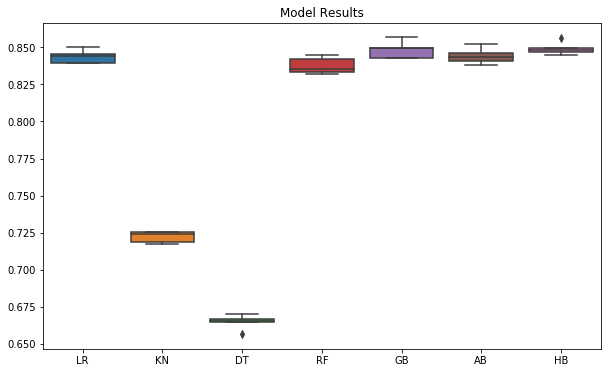

In [19]:
models = []
models.append(('LR', LogisticRegression(solver='liblinear', random_state=123)))
models.append(('KN', KNeighborsClassifier(n_neighbors=3)))
models.append(('DT', DecisionTreeClassifier(random_state=123)))
models.append(('RF', RandomForestClassifier(random_state=123)))
models.append(('GB', GradientBoostingClassifier(random_state=123)))
models.append(('AB', AdaBoostClassifier(random_state=123)))
models.append(('HB', HistGradientBoostingClassifier(random_state=123)))


results = []
names = []
for name, model in models:
    pipe = make_pipeline(ct, MultiOutputClassifier(model))
    cv_results = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc') 
    results.append(cv_results)
    names.append(name)
    msg = "{}: AUC = {:.4} \u00B1 {:.4}".format(name , cv_results.mean(), cv_results.std())
    print(msg)

plt.figure(figsize=(10,6))
sns.boxplot(names, results)
plt.title('Model Results')
plt.show()

In [20]:
estimator = HistGradientBoostingClassifier(random_state=123)

In [21]:
estimators = MultiOutputClassifier(estimator)

In [22]:
pipe = make_pipeline(ct, estimators)

In [23]:
# Grid Search

In [24]:
params = {}

# Pre-processing params
params['columntransformer__pipeline__simpleimputer__add_indicator'] = [False, True]
params['columntransformer__simpleimputer__add_indicator'] = [False, True]

# HB params
params["multioutputclassifier__estimator__max_iter"] = [100, 200, 500, 1000]
params["multioutputclassifier__estimator__max_depth"] = [2, 5, 10, 20, 30, 50]
params["multioutputclassifier__estimator__min_samples_leaf"] = [1, 5, 10, 20]
params["multioutputclassifier__estimator__l2_regularization"] = [0.1, 1, 10]

In [25]:
grid = RandomizedSearchCV(pipe, params, cv=5, scoring='roc_auc', random_state=123)
grid.fit(X, y);

In [26]:
results = pd.DataFrame(grid.cv_results_)
results.sort_values('rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_multioutputclassifier__estimator__min_samples_leaf,param_multioutputclassifier__estimator__max_iter,param_multioutputclassifier__estimator__max_depth,param_multioutputclassifier__estimator__l2_regularization,param_columntransformer__simpleimputer__add_indicator,param_columntransformer__pipeline__simpleimputer__add_indicator,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,7.091087,0.516314,0.056513,0.002684,10,100,30,10,True,True,{'multioutputclassifier__estimator__min_sample...,0.866342,0.865483,0.866357,0.874912,0.863566,0.867332,0.003924,1
1,6.683077,0.285259,0.050211,0.002040,5,100,50,1,True,True,{'multioutputclassifier__estimator__min_sample...,0.865909,0.865164,0.864958,0.872921,0.862488,0.866288,0.003511,2
3,31.033975,0.442221,0.110926,0.013120,20,500,50,10,True,True,{'multioutputclassifier__estimator__min_sample...,0.861161,0.860753,0.860536,0.870470,0.859957,0.862575,0.003966,3
9,79.530577,1.349759,0.186545,0.024358,10,1000,30,0.1,True,True,{'multioutputclassifier__estimator__min_sample...,0.850181,0.849425,0.848537,0.858903,0.847594,0.850928,0.004081,4
5,2.871730,0.059899,0.040809,0.002713,5,100,5,1,False,False,{'multioutputclassifier__estimator__min_sample...,0.849238,0.846722,0.850488,0.857956,0.845586,0.849998,0.004344,5
2,2.358196,0.093172,0.072216,0.008567,10,500,2,1,False,False,{'multioutputclassifier__estimator__min_sample...,0.850089,0.846233,0.849623,0.857864,0.844880,0.849738,0.004518,6
4,0.684355,0.001772,0.036808,0.000400,1,100,2,1,False,False,{'multioutputclassifier__estimator__min_sample...,0.846277,0.839547,0.846978,0.852697,0.839210,0.844942,0.005060,7
8,23.514524,0.327277,0.084421,0.012625,5,500,30,0.1,False,False,{'multioutputclassifier__estimator__min_sample...,0.839603,0.836908,0.841768,0.849344,0.836253,0.840775,0.004716,8
6,50.726296,1.226267,0.131130,0.012054,10,1000,20,0.1,False,True,{'multioutputclassifier__estimator__min_sample...,0.831463,0.831207,0.832457,0.842298,0.829941,0.833473,0.004485,9
7,72.584164,0.669837,0.181241,0.017490,20,1000,10,0.1,False,False,{'multioutputclassifier__estimator__min_sample...,0.827834,0.825274,0.827497,0.836200,0.824200,0.828201,0.004224,10


In [27]:
print(F"Grid best score: {grid.best_score_}")
print('')
print(F"Grid best score: {grid.best_params_}")

Grid best score: 0.8673319180682328

Grid best score: {'multioutputclassifier__estimator__min_samples_leaf': 10, 'multioutputclassifier__estimator__max_iter': 100, 'multioutputclassifier__estimator__max_depth': 30, 'multioutputclassifier__estimator__l2_regularization': 10, 'columntransformer__simpleimputer__add_indicator': True, 'columntransformer__pipeline__simpleimputer__add_indicator': True}


In [28]:
joblib.dump(grid.best_estimator_, 'joblib/grid_best_hb.joblib')

['joblib/grid_best_hb.joblib']

In [29]:
test_features_df = pd.read_csv('data/test_set_features.csv', index_col="respondent_id")

In [30]:
test_probas = grid.predict_proba(test_features_df)

In [31]:
submission_df = pd.read_csv('data/submission_format.csv', index_col="respondent_id")

In [32]:
submission_df.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.5,0.7
26708,0.5,0.7
26709,0.5,0.7
26710,0.5,0.7
26711,0.5,0.7


In [33]:
# Make sure we have the rows in the same order
np.testing.assert_array_equal(test_features_df.index.values, submission_df.index.values)

# Save predictions to submission data frame
submission_df["h1n1_vaccine"] = test_probas[0][:, 1]
submission_df["seasonal_vaccine"] = test_probas[1][:, 1]

submission_df.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.113876,0.211559
26708,0.034278,0.042340
26709,0.146502,0.637386
26710,0.718581,0.890837
26711,0.256569,0.472377


In [34]:
submission_df.to_csv('results/20200503_submission_hb.csv', index=True)